In [1]:
# Importing Python libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
import csv
import cv2
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg

Using TensorFlow backend.


# Step 1: Data Loading

This dataset contains more than 8,000 frame images taken from the 3 cameras (3 images for each frame), in addition to a csv file with the steering angle, throttle, brake, and speed during each frame.

In [2]:
data_dir = './data/'
labels_file = './data/driving_log.csv'

In [3]:
def load_data(labels_file, test_size):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            labels_file: The labels CSV file.
            test_size: The size of the testing set.
    """
    labels = pd.read_csv(labels_file)
    X = labels[['center', 'left', 'right']].values
    y = labels['steering'].values
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=0)

    return X_train, X_valid, y_train, y_valid

In [4]:
def load_image(data_dir, image_file):
    """
    Load RGB image.
        Parameters:
            data_dir: The directory where the images are.
            image_file: The image file name.
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))

In [5]:
data = load_data(labels_file, 0.2)

In [6]:
def display(image, angle, label):
    plt.imshow(image)
    plt.xlabel("Steering angle: {:.5f}".format(angle))
    plt.title(label)
    plt.xticks([])
    plt.yticks([])
    plt.show()

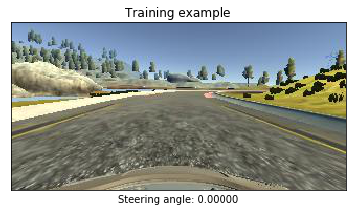

In [7]:
image = load_image(data_dir, str(data[0][0][0]))
steering_angle = data[2][0]
label = "Training example"
display(image, steering_angle, label)

# Step 2: Data Preprocessing¶

Preprocessing Steps:

- Cropping the image to cut off the sky scene and the car front
- Resizing the image to (66 * 200), the image size that the model expects
- Converting the image to the YUV color space
- Normalizing the images (by dividing image data by 127.5 and subtracting 1.0). As stated in the Model Architecture section, this is to avoid saturation and make gradients work better).


In [8]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

In [9]:
def preprocess(img):
    """
    Preprocessing (Crop - Resize - Convert to YUV) the input image.
        Parameters:
            img: The input image to be preprocessed.
    """
    # Cropping the image
    img = img[60:-25, :, :]
    # Resizing the image
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
    # Converting the image to YUV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return img

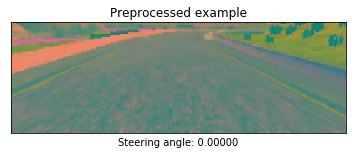

In [10]:
image = preprocess(load_image(data_dir, str(data[0][0][0])))
steering_angle = data[2][0]
label = "Preprocessed example"
display(image, steering_angle, label)

# Step 3: Data Augmentation

Augmentation Steps:

- Adjusting the steering angle of random images.
- Flipping random images horizontaly, with steering angle adjustment.
- Shifting (Translating) random images, with steering angle adjustment.
- Adding shadows to random images.
- Altering the brightness of random images.

In [11]:
def random_adjust(data_dir, center, left, right, steering_angle):
    """
    Adjusting the steering angle of random images.
        Parameters:
            data_dir: The directory where the images are.
            center: Center image.
            left: Left image.
            right: Right image
            steering_angle: The steering angle of the input frame.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load_image(data_dir, left), steering_angle + 0.2
    elif choice == 1:
        return load_image(data_dir, right), steering_angle - 0.2
    return load_image(data_dir, center), steering_angle

In [12]:
def random_flip(image, steering_angle):
    """
    Randomly flipping the input image horizontaly, with steering angle adjustment.
        Parameters:
            image: The input image.
            steering_angle: The steering angle related to the input image.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

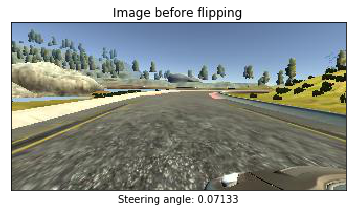

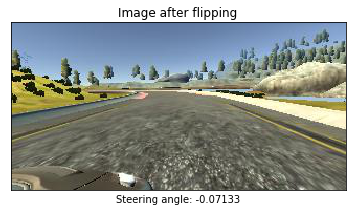

In [13]:
image = load_image(data_dir, str(data[0][0][1]))
steering_angle = data[2][1]
label = "Image before flipping"
display(image, steering_angle, label)

image = random_flip(image, steering_angle)
label = "Image after flipping"
display(image[0], image[1], label)

In [14]:
def random_shift(image, steering_angle, range_x, range_y):
    """
    Shifting (Translating) the input images, with steering angle adjustment.
        Parameters:
            image: The input image.
            steering_angle: The steering angle related to the input image.
            range_x: Horizontal translation range.
            range_y: Vertical translation range.
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

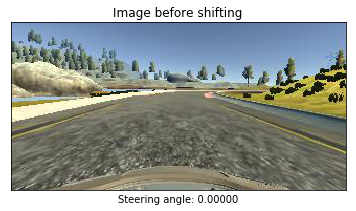

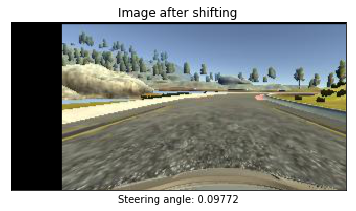

In [15]:
image = load_image(data_dir, str(data[0][0][0]))
steering_angle = data[2][0]
label = "Image before shifting"
display(image, steering_angle, label)

image = random_shift(image, steering_angle, 100, 10)
label = "Image after shifting"
display(image[0], image[1], label)

In [16]:
def random_shadow(image):
    """
    Adding shadow to the input image.
        Parameters:
            image: The input image.
    """
    bright_factor = 0.3
    x = random.randint(0, image.shape[1])
    y = random.randint(0, image.shape[0])
    width = random.randint(image.shape[1], image.shape[1])
    if(x + width > image.shape[1]):
        x = image.shape[1] - x
    height = random.randint(image.shape[0], image.shape[0])
    if(y + height > image.shape[0]):
        y = image.shape[0] - y
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image[y:y+height,x:x+width,2] = image[y:y+height,x:x+width,2]*bright_factor
    return cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

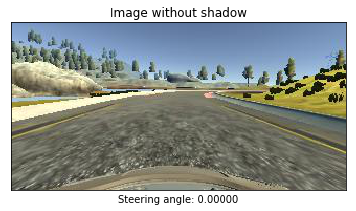

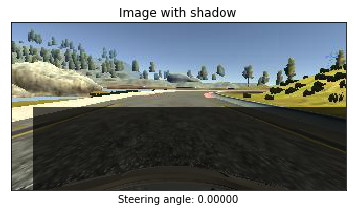

In [17]:
image = load_image(data_dir, str(data[0][0][0]))
steering_angle = data[2][0]
label = "Image without shadow"
display(image, steering_angle, label)

image = random_shadow(image)
label = "Image with shadow"
display(image, steering_angle, label)

In [18]:
def random_brightness(image):
    """
    Altering the brightness of the input image.
        Parameters:
            image: The input image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

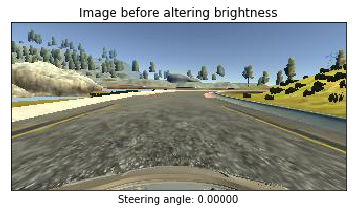

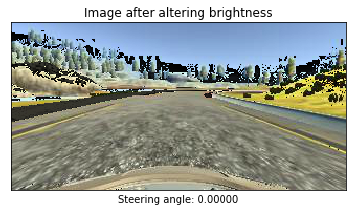

In [19]:
image = load_image(data_dir, str(data[0][0][0]))
steering_angle = data[2][0]
label = "Image before altering brightness"
display(image, steering_angle, label)

image = random_brightness(image)
label = "Image after altering brightness"
display(image, steering_angle, label)

In [20]:
def augument(data_dir, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust the associated steering angle.
        Parameters:
            data_dir: The directory where the images are.
            center: Center image.
            left: Left image.
            right: Right image
            steering_angle: The steering angle related to the input frame.
            range_x (Default = 100): Horizontal translation range.
            range_y (Default = 10): Vertival translation range.
    """
    image, steering_angle = random_adjust(data_dir, center, left, right, steering_angle)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_shift(image, steering_angle, range_x, range_y)
    image = random_shadow(image)
    image = random_brightness(image)
    return image, steering_angle

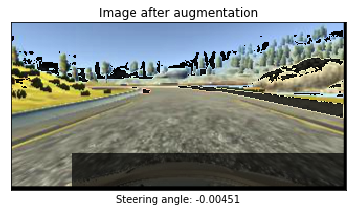

In [21]:
steering_angle = data[2][0]
center = data[0][0][0]
left = data[0][0][1]
right = data[0][0][2]
range_x = 100
range_y = 10

image, steering_angle = augument(data_dir, center, left, right, steering_angle, range_x, range_y)
label = "Image after augmentation"
display(image, steering_angle, label)

# Step 4: Model Architecture

In this step, we will design and implement a deep learning model that can clone the vehicle's behavior. We'll use a convolutional neural network (CNN) to map raw pixels from a single front-facing camera directly to steering commands.

I've added a dropout layer to the model to prevent overfitting.

In [22]:
def NVIDIA_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
    model.add(Conv2D(24, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Conv2D(36, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Conv2D(48, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.summary()
    return model

# Step 5: Model Training & Evaluation

- I've splitted the data into 80% training set and 20% validation set to measure the performance after each epoch.
- I used Mean Squared Error (MSE) as a loss function to measure how close the model predicts to the given steering angle for each input frame.
- I used the Adaptive Moment Estimation (Adam) Algorithm minimize to the loss function. Adam is an optimization algorithm introduced by D. Kingma and J. Lei Ba in a 2015 paper named Adam: A Method for Stochastic Optimization. Adam algorithm computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients like Adadelta and RMSprop algorithms, Adam also keeps an exponentially decaying average of past gradients mtmt, similar to momentum algorithm, which in turn produce better results.
- I used ModelCheckpoint from Keras to check the validation loss after each epoch and save the model only if the validation loss reduced.

In [23]:
batch_size = 40
samples_per_epoch = 20000
nb_epoch = 10

In [28]:
def batcher(data_dir, image_paths, steering_angles, batch_size, training_flag):
    """
    Generate a training image given image paths and the associated steering angles
        Parameters:
            data_dir: The directory where the images are.
            image_paths: Paths to the input images.
            steering_angle: The steering angle related to the input frame.
            batch_size: The batch size used to train the model.
            training_flag: A flag to determine whether we're in training or validation mode.
    """
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            if training_flag and np.random.rand() < 0.6:
                image, steering_angle = augument(data_dir, center, left, right, steering_angle)
            else:
                image = load_image(data_dir, center) 
            images[i] = preprocess(image)
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        yield images, steers

In [29]:
def train_model(model, X_train, X_valid, y_train, y_valid):
    print(len(X_train))
    checkpoint = ModelCheckpoint('model-{val_loss:03f}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')
    model.compile(loss='mse', optimizer=Adam(lr=1.0e-4))
    model.fit_generator(batcher(data_dir, X_train, y_train, batch_size, True),
                        samples_per_epoch,
                        nb_epoch,
                        max_q_size=1,
                        validation_data=batcher(data_dir, X_valid, y_valid, batch_size, False),
                        nb_val_samples=len(X_valid),
                        callbacks=[checkpoint],
                        verbose=1)

In [30]:
model = NVIDIA_model()
train_model(model, *data)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), activation="relu")`
  after removing the cwd from sys.path.
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), activation="relu")`
  """
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), activation="relu")`
  
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  import sys
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 18, 64)         0         
__________

# Step 5: Model Testing on the simulator

The model was able to drive the car safely through the track without leaving the drivable portion of the track surface.

Conclusion:

The model was able to drive the car through the first track. I've only used the training data provided by Udacity. One way to improve the model is to collect more data from the mountain track, and train the model to go through this challenging track as well. We can also modify drive.py script to change the maximum speed and make it related to the steering angle, in order to make the car speed up in the straight parts of the track, and slow down in the curved parts.